In [2]:
import numpy as np 
import pandas as pd
import random

/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
from trajDTW import (
        anndata_to_3d_matrix, 
        calculate_trajectory_conservation,
        TrajectoryFitter,
        get_most_conserved_samples,
        fit_with_conserved_samples,
        extract_pairwise_distances,
        create_gene_position_mapping
)

In [22]:
outputdir = "../../../process/trajectory/20250417_mineralization"

In [5]:
filter_genes_odonto = pd.read_csv("../../../process/trajectory/20250415_odonto_run_3/filtered_genes.csv",index_col=0)["0"]
filter_genes_odonto
batch_names_odonto = pd.read_csv("../../../process/trajectory/20250415_odonto_run_3/batch_names.csv",index_col=0)["0"]
batch_names_odonto
reshaped_data_odonto = np.load("../../../process/trajectory/20250415_odonto_run_3/reshaped_data.npy")

In [6]:
filter_genes_bone = pd.read_csv("../../../process/trajectory/20250415_bone_run_2/filtered_genes.csv",index_col=0)["0"]
filter_genes_bone
batch_names_bone = pd.read_csv("../../../process/trajectory/20250415_bone_run_2/batch_names.csv",index_col=0)["0"]
batch_names_bone
reshaped_data_bone = np.load("../../../process/trajectory/20250415_bone_run_2/reshaped_data.npy")

In [8]:
filter_genes_epi = pd.read_csv("../../../process/trajectory/20250417_epi_run_6/filtered_genes.csv",index_col=0)["0"]
batch_names_epi = pd.read_csv("../../../process/trajectory/20250417_epi_run_6/batch_names.csv",index_col=0)["0"]
reshaped_data_epi = np.load("../../../process/trajectory/20250417_epi_run_6/reshaped_data.npy")

In [13]:
reshaped_data_bone.shape

(68, 100, 13963)

In [14]:
batch_names_bone

0      Ablation_Matsushita_abl14
1      Ablation_Matsushita_cxcl1
2      Ablation_Matsushita_cxcl2
3     Ablation_Matsushita_treat1
4     Ablation_Matsushita_treat2
                 ...            
63           lambdoid_Holmes_E18
64           lambdoid_Holmes_P10
65           lambdoid_Holmes_P28
66           sagittal_Holmes_E18
67           sagittal_Holmes_P28
Name: 0, Length: 68, dtype: object

In [16]:
import numpy as np
import pandas as pd

# 1. Find the intersection of genes across the three datasets
common_genes = set(filter_genes_odonto).intersection(set(filter_genes_bone)).intersection(set(filter_genes_epi))
common_genes = list(common_genes)  # Convert to list for easier indexing

print(f"Number of common genes across all three datasets: {len(common_genes)}")

# 2. Get indices of common genes in each dataset
odonto_indices = [np.where(filter_genes_odonto == gene)[0][0] for gene in common_genes]
bone_indices = [np.where(filter_genes_bone == gene)[0][0] for gene in common_genes]
epi_indices = [np.where(filter_genes_epi == gene)[0][0] for gene in common_genes]

# 3. Extract only the common genes from each dataset
# Shape: (batch, pseudotime, common_genes)
odonto_data_common = reshaped_data_odonto[:, :, odonto_indices]
bone_data_common = reshaped_data_bone[:, :, bone_indices]
epi_data_common = reshaped_data_epi[:, :, epi_indices]

print(f"Shapes after filtering to common genes:")
print(f"Odonto: {odonto_data_common.shape}")
print(f"Bone: {bone_data_common.shape}")
print(f"Epi: {epi_data_common.shape}")

# 4. Concatenate the datasets along the first dimension (batch)
# This preserves the pseudotime and gene dimensions
combined_data = np.concatenate([odonto_data_common, bone_data_common, epi_data_common], axis=0)

print(f"Shape of combined data (all batches, same pseudotime points, common genes): {combined_data.shape}")

# 5. Create a combined batch names list
combined_batch_names = list(batch_names_odonto) + list(batch_names_bone) + list(batch_names_epi)
print(f"Combined batch names: {combined_batch_names}")

# If you want to save the results
#np.save("combined_reshaped_data.npy", combined_data)


Number of common genes across all three datasets: 13249
Shapes after filtering to common genes:
Odonto: (9, 100, 13249)
Bone: (68, 100, 13249)
Epi: (6, 100, 13249)
Shape of combined data (all batches, same pseudotime points, common genes): (83, 100, 13249)
Combined batch names: ['CAGE_Chiba_Epi', 'CAGE_Chiba_Mes', 'Incisor_Luo_E165', 'Molar_Qian', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNc_Junjun_P7.5', 'ToothNiche_Hong_PN1', 'ToothNiche_Hong_PN7', 'Ablation_Matsushita_abl14', 'Ablation_Matsushita_cxcl1', 'Ablation_Matsushita_cxcl2', 'Ablation_Matsushita_treat1', 'Ablation_Matsushita_treat2', 'Bmsc2019_Regev_b1', 'Bmsc2019_Regev_b2', 'Bmsc2019_Regev_b3', 'Bmsc2019_Regev_b4', 'Bmsc2019_Regev_bm1', 'Bmsc2019_Regev_bm2', 'Bmsc2019_Regev_bm4', 'Bmsc2019_Regev_samp1', 'Bmsc2019_Regev_samp2', 'Bmsc2019_Regev_samp3', 'Bmsc2019_Regev_samp4', 'Bmsc2019_Regev_samp5', 'Bmsc2019_Regev_samp6', 'BmscChondro_Long', 'BmscEndosteal_Ono_Fgfr3CE', 'BmscEndosteal_Ono_Fgfr3CEp53cHet', 'BmscEndosteal_Ono

In [19]:

# Check the current number of bone samples
n_bone_samples = reshaped_data_bone.shape[0]
print(f"Current number of bone samples: {n_bone_samples}")

# If we have more than 10 bone samples, downsample to 10
if n_bone_samples > 10:
    # Option 1: Randomly select 10 samples
    random.seed(42)  # Set seed for reproducibility
    selected_indices = sorted(random.sample(range(n_bone_samples), 10))
    
    # Option 2: Alternative - select evenly spaced samples
    # selected_indices = np.linspace(0, n_bone_samples-1, 10, dtype=int)
    
    print(f"Selected bone sample indices: {selected_indices}")
    
    # Subset the bone data and batch names
    reshaped_data_bone_downsampled = reshaped_data_bone[selected_indices, :, :]
    batch_names_bone_downsampled = [batch_names_bone[i] for i in selected_indices]
    
    print(f"Shape of downsampled bone data: {reshaped_data_bone_downsampled.shape}")
    
    # Update the common genes extraction with the downsampled data
    bone_data_common = reshaped_data_bone_downsampled[:, :, bone_indices]
    
    # Recombine the datasets
    combined_data = np.concatenate([odonto_data_common, bone_data_common, epi_data_common], axis=0)
    
    # Update combined batch names
    combined_batch_names = list(batch_names_odonto) + list(batch_names_bone_downsampled) + list(batch_names_epi)
    
    print(f"New shape of combined data: {combined_data.shape}")
    print(f"New number of combined batches: {len(combined_batch_names)}")
else:
    print("No downsampling needed, already have 10 or fewer bone samples")


Current number of bone samples: 68
Selected bone sample indices: [3, 6, 8, 14, 28, 31, 35, 43, 47, 61]
Shape of downsampled bone data: (10, 100, 13963)
New shape of combined data: (25, 100, 13249)
New number of combined batches: 25


In [23]:
outputdir + "combined_reshaped_data.npy"

'../../../process/trajectory/20250417_mineralizationcombined_reshaped_data.npy'

In [24]:
np.save( outputdir + "/combined_reshaped_data.npy", combined_data)
pd.DataFrame(combined_batch_names).to_csv(outputdir +"/combined_batch_names_downsampled.csv")
pd.DataFrame(common_genes).to_csv(outputdir + "/combined_filtered_genes.csv")

shape of reshaped_data:  (25, 100, 13249)
Start calculating trajectory conservation...
Calculating pairwise DTW distances for 13249 genes across 25 samples (300 pairwise comparisons per gene)...
Using normalization method: zscore
Filtering samples by variation: threshold=1, metric=max
Processing 13249 genes using 36 parallel jobs...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=36)]: Done 1007 tasks      | elapsed:    8.4s
[Parallel(n_jobs=36)]: Done 1630 tasks      | elapsed:   13.6s
[Parallel(n_jobs=36)]: Done 2128 tasks      | elapsed:   19.2s
[Parallel(n_jobs=36)]: Done 2700 tasks      | elapsed:   25.6s
[Parallel(n_jobs=36)]: Done 3615 tasks      | elapsed:   35.6s
[Parallel(n_jobs=36)]: Done 5053 tasks      | elapsed:   50.0s
[Parallel(n_jobs=36)]: Done 6091 tasks      | elapsed:  1.0min
[Parallel(n_jobs=36)]: Done 7214 tasks      | elapsed:  1.2min
[Parallel(n_jobs=36)]: Done 8570 tasks      | elapsed:  1.4min
[Parallel(n_jobs=36)]: Done 10490 tasks      | elapsed:  1.7min
[Parallel(n_jobs=36)]: Done 12272 tasks      | elapsed:  2.0min
[Parallel(n_jobs=36)]: Done 13249 out of 13249 | elapsed:  2.3min finished


Pairwise distances saved to ../../../process/trajectory/20250417_mineralization/pairwise_distances.csv
Creating specialized datasets for each gene...
  Gene Stx18: Using 12 most conserved samples out of 25 total (position: 8678)
  Gene Dynlrb1: Using 12 most conserved samples out of 25 total (position: 1096)
  Gene Ltc4s: Using all samples (gene not found in conserved samples dict) (position: 1)
  Gene Rpf1: Using all samples (gene not found in conserved samples dict) (position: 2)
  Gene Pafah1b2: Using all samples (gene not found in conserved samples dict) (position: 3)
  Gene Serinc2: Using all samples (gene not found in conserved samples dict) (position: 4)
  Gene Pcgf2: Using all samples (gene not found in conserved samples dict) (position: 5)
  Gene Dennd2c: Using all samples (gene not found in conserved samples dict) (position: 6)
  Gene Hist2h2aa1: Using all samples (gene not found in conserved samples dict) (position: 7)
  Gene Kif1bp: Using all samples (gene not found in cons

Processing genes:   0%|          | 0/8000 [00:00<?, ?it/s]


Spline Fitting Results Comparison:
Standard approach - mean DTW distance: 59.4231
DTW-optimized approach - mean DTW distance: 59.4001
Improvement: 0.0230
Percentage improvement: 0.04%


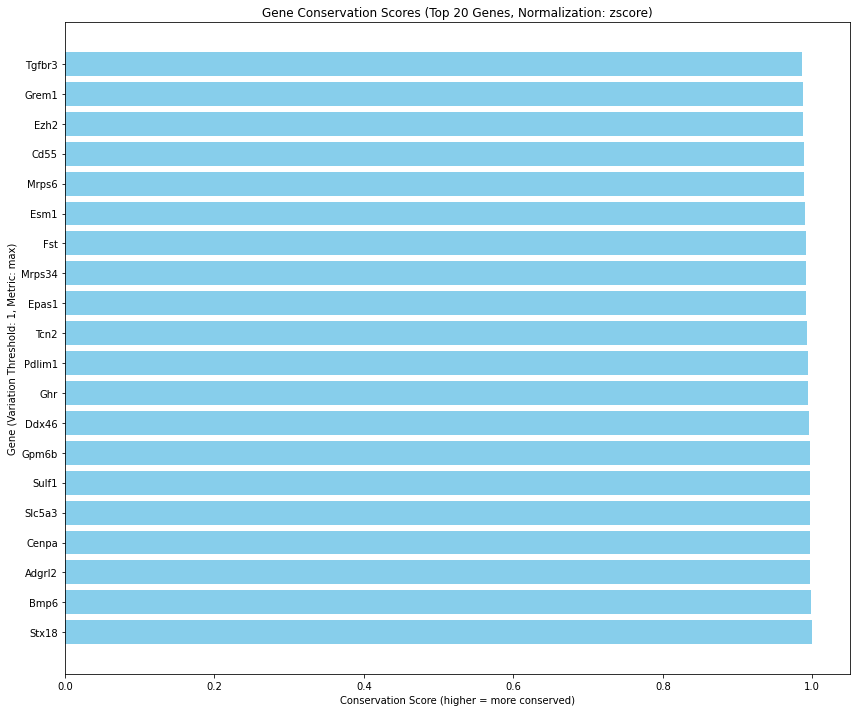

In [29]:

# Define sample variation filtering parameters
VARIATION_FILTERING = {
    'off': {
        'filter_samples_by_variation': False
    },
    'basic': {
        'filter_samples_by_variation': True,
        'variation_threshold': 1,  # Minimum coefficient of variation
        'variation_metric': 'max',
        'min_valid_samples': 2       # At least 2 samples needed
    },
    'stringent': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.2, 
        'variation_metric': 'max',
        'min_valid_samples': 2
    }
}

# Choose filtering level
variation_filter_level = 'basic'  # Options: 'off', 'basic', 'stringent'
filter_params = VARIATION_FILTERING[variation_filter_level]
filtered_genes = common_genes
print("shape of reshaped_data: ", combined_data.shape)
print("Start calculating trajectory conservation...")
conservation_results = calculate_trajectory_conservation(
    trajectory_data=combined_data,
    gene_names=filtered_genes, 
    save_dir=outputdir,
    prefix="traj_conservation",
    dtw_radius=3,            # Radius parameter for fastdtw
    use_fastdtw=True,
    normalize='zscore',      # Normalize trajectories before DTW calculation
    **filter_params          # Apply sample variation filtering
)
_ = extract_pairwise_distances(conservation_results, output_csv = outputdir + "/pairwise_distances.csv")
selected_genes = np.array(conservation_results["conservation_scores"]["gene"].head(n=8000))
gene_mapping = create_gene_position_mapping(selected_genes, filtered_genes)
conservation_results["conservation_scores"].to_csv(outputdir + "/conservation_scores.csv")
fit_res = fit_with_conserved_samples(
    reshaped_data = combined_data, gene_names = selected_genes,  gene_positions = gene_mapping, 
    conserved_samples = conservation_results["conserved_samples"], interpolation_factor=1,
    top_n_genes=None, verbose=True, spline_smoothing=2,n_jobs = -1
)

fitdf = pd.DataFrame(fit_res["standard_results"]["fitted_trajectories"])
fitdf.columns = fit_res["top_gene_names"]

fitdfOptimized = pd.DataFrame(fit_res["optimized_results"]["fitted_trajectories"])
fitdfOptimized.columns = fit_res["top_gene_names"]

fitdf.to_csv(outputdir + "/fitted_trajectories.csv")
fitdfOptimized.to_csv(outputdir + "/fitted_trajectories_optimized.csv")